In [6]:
import onnxruntime
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import json
import matplotlib.pyplot as plt
import os

In [7]:
# Load config files
def load_configs(model_dir):
    with open(os.path.join(model_dir, 'config.json')) as f:
        config = json.load(f)
    with open(os.path.join(model_dir, 'preprocessor_config.json')) as f:
        preprocessor_config = json.load(f)
    return config, preprocessor_config

In [8]:
model_dir = 'mobilenet_v2_1.0_224-plant-disease-identification_onnx'
config, preprocessor_config = load_configs(model_dir)
ort_session = onnxruntime.InferenceSession(os.path.join(model_dir, 'model.onnx'))

In [ ]:
def predict_plant_disease(image_path_or_url, top_k=5):
    """
    Predict plant disease from an image using ONNX model
    
    Args:
        image_path_or_url: Path to local image file or URL
        top_k: Number of top predictions to return
    
    Returns:
        List of tuples (label, confidence_score)
        The input image (PIL Image)
    """
    
    # Load image
    if image_path_or_url.startswith('http'):
        response = requests.get(image_path_or_url)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path_or_url)
    
    # Convert to RGB if necessary
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Preprocess the image
    width, height = image.size
    size = preprocessor_config['size']['shortest_edge']
    ratio = float(size) / min(width, height)
    new_size = tuple([int(x * ratio) for x in (width, height)])
    image = image.resize(new_size, Image.BILINEAR)
    
    if preprocessor_config['do_center_crop']:
        crop_height = preprocessor_config['crop_size']['height']
        crop_width = preprocessor_config['crop_size']['width']
        top = (new_size[1] - crop_height) // 2
        left = (new_size[0] - crop_width) // 2
        image = image.crop((left, top, left + crop_width, top + crop_height))
    
    # Convert to numpy array and normalize
    image_array = np.array(image).astype(np.float32)
    if preprocessor_config['do_rescale']:
        image_array = image_array * np.float32(preprocessor_config['rescale_factor'])
    if preprocessor_config['do_normalize']:
        mean = np.array(preprocessor_config['image_mean'], dtype=np.float32)
        std = np.array(preprocessor_config['image_std'], dtype=np.float32)
        image_array = (image_array - mean) / std
    
    # Add batch dimension and transpose to CHW
    image_array = np.transpose(image_array, (2, 0, 1))
    image_array = np.expand_dims(image_array, axis=0)
    
    # Run inference
    ort_inputs = {ort_session.get_inputs()[0].name: image_array}
    ort_outs = ort_session.run(None, ort_inputs)
    predictions = ort_outs[0]
    
    # Get top-k predictions
    probs = np.exp(predictions[0]) / np.sum(np.exp(predictions[0]))
    top_indices = np.argsort(probs)[-top_k:][::-1]
    results = []
    for idx in top_indices:
        confidence = float(probs[idx]) * 100  
        label = config['id2label'][str(idx)]
        results.append((label, round(confidence, 2)))
        
    return results, image


Testing with sample image...


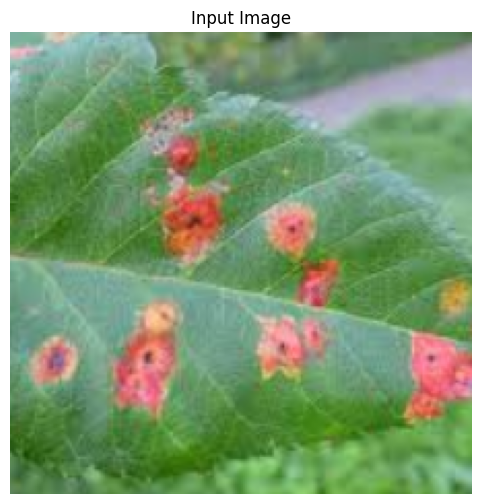


Top 5 Predictions:
--------------------------------------------------
1. Cedar Apple Rust: 93.9600 (93.96%)
2. Apple with Black Rot: 3.3900 (3.39%)
3. Grape with Esca (Black Measles): 0.9400 (0.94%)
4. Bell Pepper with Bacterial Spot: 0.4000 (0.4%)
5. Corn (Maize) with Common Rust: 0.2600 (0.26%)


In [15]:
sample_image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZ45DSHrdt0fGo5JQdiXeRAO4RVIBhDWi25g&s"

print("\nTesting with sample image...")
try:
    predictions, image = predict_plant_disease(sample_image_url)
    results = []

    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    plt.show()
    
    # Print predictions
    print("\nTop 5 Predictions:")
    print("-" * 50)
    for i, (label, confidence) in enumerate(predictions, 1):
        print(f"{i}. {label}: {confidence:.4f} ({confidence}%)")
        
except Exception as e:
    print(f"Error with sample image: {e}")